In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import itertools
import tensorflow as tf
# import tensorflow_hub as hub

In [2]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Flatten, 
                                     Conv1D, MaxPooling1D, Dropout, 
                                     GlobalMaxPooling1D, Activation, 
                                     Embedding, Bidirectional, LSTM, 
                                     BatchNormalization)

In [3]:
from collections import Counter
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (classification_report,accuracy_score,
                             precision_score,recall_score,f1_score, 
                             confusion_matrix, precision_recall_curve)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import (LabelEncoder,
                                   OneHotEncoder,
                                   LabelBinarizer)

In [ ]:
# https://www.kaggle.com/code/srajpara/protein-classification-rnn-lstm-v-1

# Load Data

In [7]:
data = pd.read_csv("protein_class_prep/pdb_data_no_dups.csv")

In [8]:
sequnce = pd.read_csv("protein_class_prep/pdb_data_seq.csv")

# Data Preprocessing

In [9]:
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [10]:
sequnce.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [11]:
# the same columns in both datasets
sequnce.drop(columns=['residueCount', 'macromoleculeType'], inplace=True)

In [12]:
df = data.merge(sequnce, how='inner', on='structureId')

In [13]:
# Drop rows with missing labels
df = df[[type(c) == type('') for c in df.classification.values]]
df = df[[type(c) == type('') for c in df.sequence.values]]

# select proteins
df = df[df.macromoleculeType == 'Protein']
df.reset_index()
print(df.shape)
df.head()

(346321, 16)


,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
4,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,167,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18093.78,NaN,NaN,3.09,60.30,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [14]:
# Remove some longer/shorter sequences
print(df.residueCount.quantile(0.9))
df.residueCount.describe()

5628.0


count    346321.000000
mean       4708.585243
std       26484.309151
min           3.000000
25%         398.000000
50%         856.000000
75%        1976.000000
max      313236.000000
Name: residueCount, dtype: float64

In [15]:
df = df.loc[df.residueCount<1200]
print(df.shape[0])
df.residueCount.describe()

212258


count    212258.000000
mean        529.197415
std         305.092634
min           3.000000
25%         280.000000
50%         485.000000
75%         768.000000
max        1198.000000
Name: residueCount, dtype: float64

Only 10 most common classes are considered - because computational limitations

at least 4015 instances per class
212258 instances before
111166 instances after


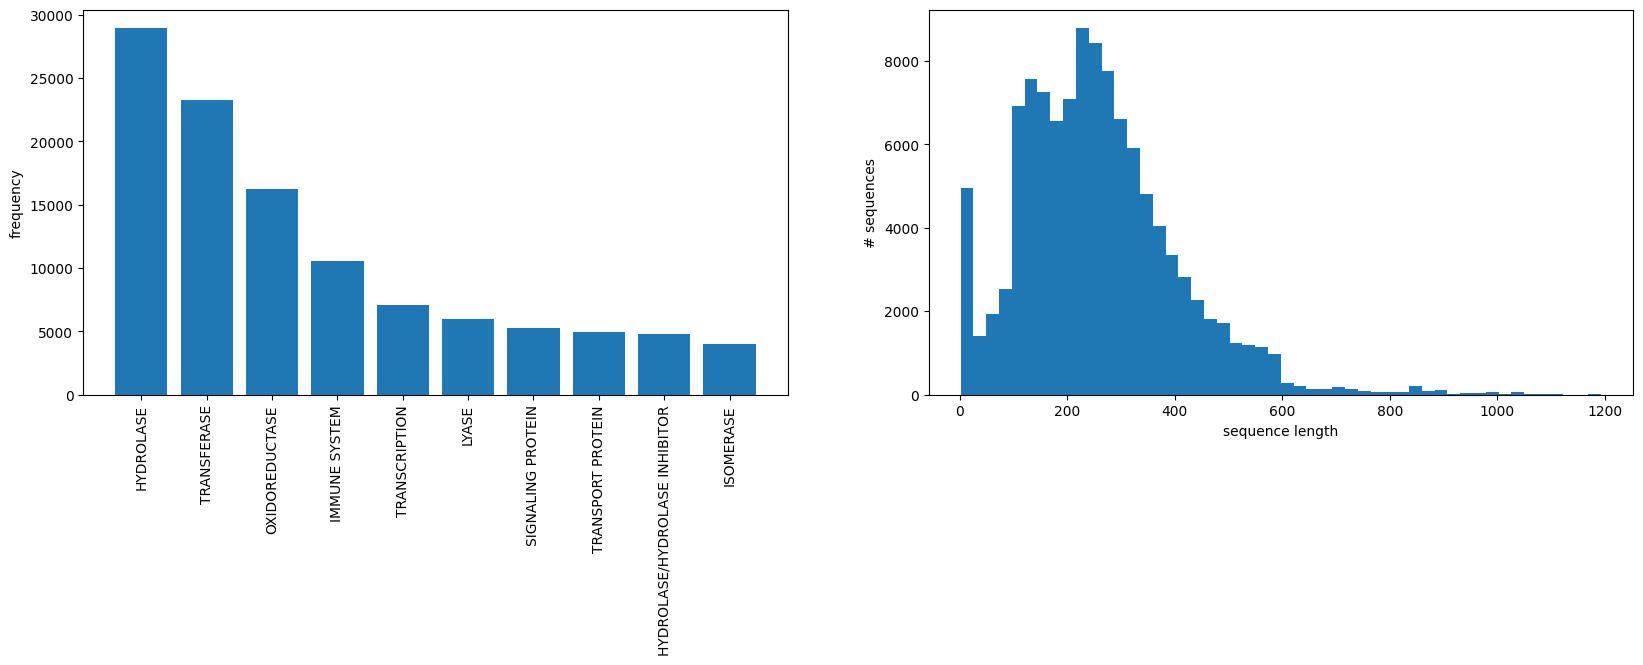

In [16]:
import matplotlib.pyplot as plt
from collections import Counter

# count numbers of instances per class
cnt = Counter(df.classification)
# select only K most common classes! - was 10 by default
top_classes = 10
# sort classes
sorted_classes = cnt.most_common()[:top_classes]
classes = [c[0] for c in sorted_classes]
counts = [c[1] for c in sorted_classes]
print("at least " + str(counts[-1]) + " instances per class")

# apply to dataframe
print(str(df.shape[0]) + " instances before")
df = df[[c in classes for c in df.classification]]
print(str(df.shape[0]) + " instances after")

seqs = df.sequence.values
lengths = [len(s) for s in seqs]

# visualize
fig, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].bar(range(len(classes)), counts)
plt.sca(axarr[0])
plt.xticks(range(len(classes)), classes, rotation='vertical')
axarr[0].set_ylabel('frequency')

axarr[1].hist(lengths, bins=50)
axarr[1].set_xlabel('sequence length')
axarr[1].set_ylabel('# sequences')
plt.show()

## Transform labels

In [17]:
X = df['sequence']
y = df['classification']

In [18]:
# encode classification labels
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

In [19]:
# maximum length of sequence, everything afterwards is discarded! Default 256
max_length = 350

#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(seqs)
X = sequence.pad_sequences(X, maxlen=max_length)

In [20]:
# number of distinct characters stored in variable max_id
# this will be part of the input shape (reps each AA)
max_id = len(tokenizer.word_index)
max_id

25

In [21]:
# total number of characters 
dataset_size = tokenizer.document_count
dataset_size

111166

In [22]:
# split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [23]:
# confirm shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((88932, 350), (22234, 350), (88932, 10), (22234, 10))

In [24]:
# create function to plot results
def plot_model_results(model):
    
    accuracy = model.history.history['accuracy']
    loss = model.history.history['loss']
    
    val_accuracy = model.history.history['val_accuracy']
    val_loss = model.history.history['val_loss']
    
    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    
    plt.ylabel('% accuracy')
    plt.xlabel('Epoch')
    #plt.ylim(0.1, 1.0)
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Model Loss')
    
    plt.ylabel('% loss')
    plt.xlabel('Epoch')
    #plt.ylim(0.1, 1.0)
    plt.legend()
    plt.show()

In [25]:
# create hyperparameters 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  mode='max', 
                                                  restore_best_weights=True, 
                                                  patience=2)

opt = tf.keras.optimizers.Adam(learning_rate= 0.001)

In [27]:
# create model
embedding_dim=25

model = Sequential()
model.add(Embedding(max_id+1,embedding_dim, input_length=max_length))

model.add(LSTM(25, return_sequences=True))

model.add(Flatten())
model.add(Dense(7125, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 25)           650       
                                                                 
 lstm (LSTM)                 (None, 350, 25)           5100      
                                                                 
 flatten (Flatten)           (None, 8750)              0         
                                                                 
 dense (Dense)               (None, 7125)              62350875  
                                                                 
 dense_1 (Dense)             (None, 10)                71260     
                                                                 
Total params: 62427885 (238.14 MB)
Trainable params: 62427885 (238.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# BECAUSE OF COMPUTATIONAL LIMITATIONS, THE MODEL WAS TRAINED IN KAGGLE - USING GPU

SEE: https://www.kaggle.com/code/davidhjek/protein-sequence-classification

In [28]:
# fit model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=early_stopping)

Epoch 1/50
 267/2780 [=>............................] - ETA: 32:35 - loss: 1.9574 - accuracy: 0.3765

KeyboardInterrupt: 

In [ ]:
# plot results
plot_model_results(model)

In [ ]:
# evaluate model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train accuracy = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test accuracy = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# classification report
print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))